In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
from scipy import stats

import constants as c
import helpers as h

from logger import setup_logger 
log = setup_logger("external-covariate-correlations-analysis")
log.setLevel("INFO")
log.info("Modules loaded.")

2025-02-05 19:04:56 - external-covariate-correlations-analysis - INFO - Modules loaded.


In [2]:
# enable latex plotting if true 
h.latex(True)

2025-02-05 19:04:56 - analysis-helpers - INFO - Enabling LaTeX for matplotlib.


In [3]:
analysis_df = pd.read_csv(c.CURRENT_NO_COVARIATES_DF)
analysis_df = h.add_helper_cols(analysis_df)


2025-02-05 19:04:56 - analysis-helpers - INFO - Found 192 tracts with at least one FloodNet sensor.
2025-02-05 19:04:56 - analysis-helpers - INFO - Found 2171 311 requests.
2025-02-05 19:04:56 - analysis-helpers - INFO - Found 878 tracts with at least one 311 report.
2025-02-05 19:04:56 - analysis-helpers - INFO - Found 1001 tracts with no DEP flooding.


In [4]:
COVARIATES = [
    'any_311_report',
    'n_311_reports',
    'any_sensors',
    'n_floodnet_sensors',
    'dep_moderate_1_frac',
    'dep_moderate_2_frac',
    'ft_elevation_min',
    'ft_elevation_mean',
    'ft_elevation_max'
]

In [5]:
# Define regression parameters for each covariate
regression_params = {
    'any_311_report': {'logistic': True, 'fit_reg': True},
    'n_311_reports': {'logistic': False, 'fit_reg': True},
    'any_sensors': {'logistic': True, 'fit_reg': True},
    'n_floodnet_sensors': {'logistic': False, 'fit_reg': True},
    'dep_moderate_1_frac': {'logistic': False, 'fit_reg': True},
    'dep_moderate_2_frac': {'logistic': False, 'fit_reg': True},
    'ft_elevation_min': {'logistic': False, 'fit_reg': True},
    'ft_elevation_mean': {'logistic': False, 'fit_reg': True},
    'ft_elevation_max': {'logistic': False, 'fit_reg': True}
}

row_mapping = {
    'any_311_report': 'Any 311 Report in Tract?',
    'n_311_reports': '\# of 311 Reports in Tract',
    'any_sensors': 'Any FloodNet sensors in Tract?',
    'n_floodnet_sensors': '\# of FloodNet sensors in Tract',
    'dep_moderate_1_frac': r'Frac. Pred. Shallow Flooding [${ft}^2$]',
    'dep_moderate_2_frac': r'Frac. Pred. Deep Flooding [${ft}^2$]',
    'ft_elevation_min': 'Minimum elevation in Tract [ft]',
    'ft_elevation_mean': 'Mean elevation in Tract[ft]',
    'ft_elevation_max': 'Maximum elevation in Tract [ft]'
}

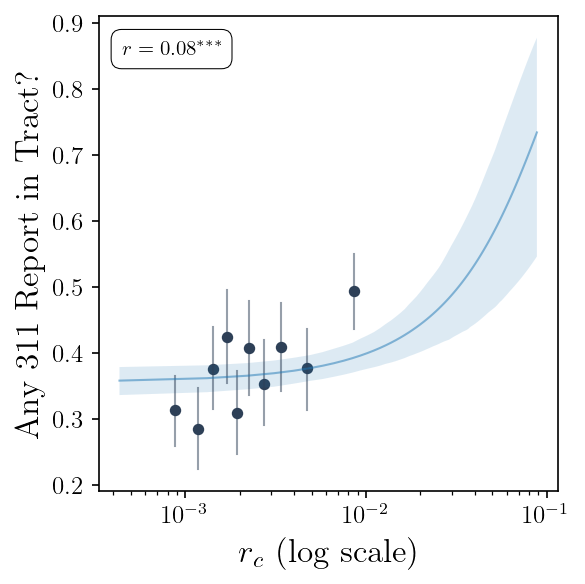

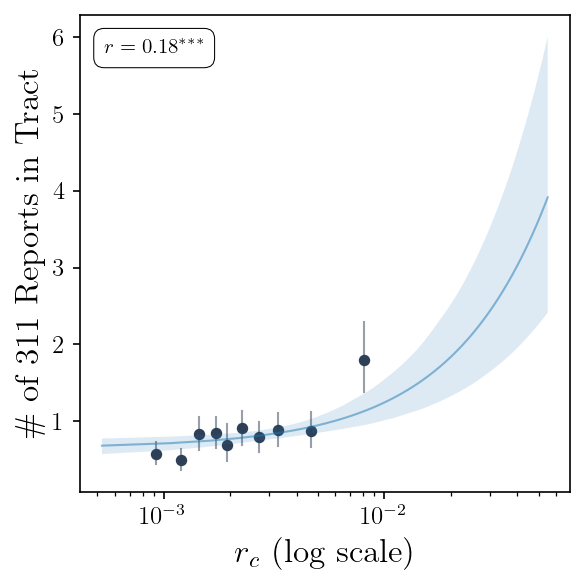

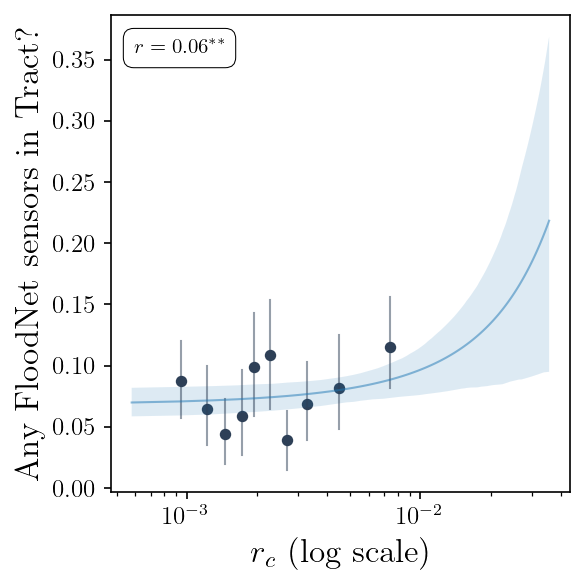

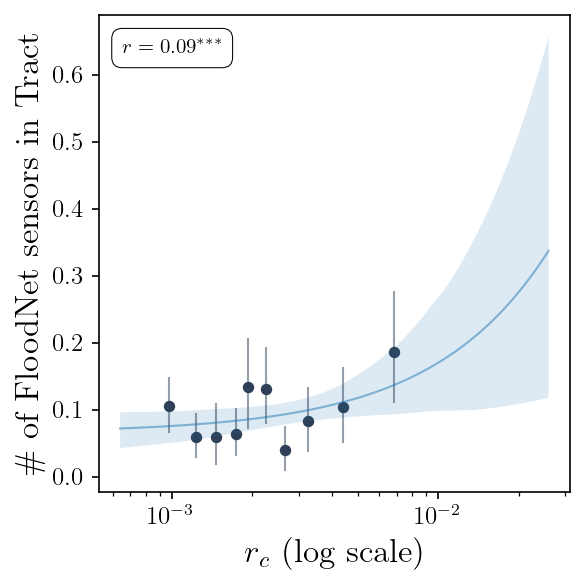

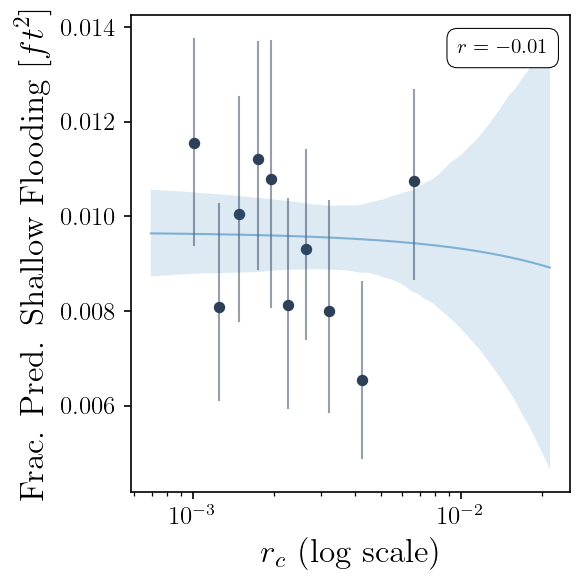

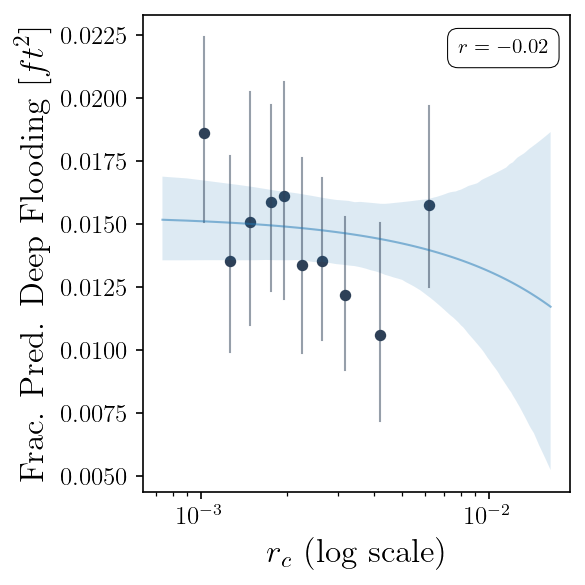

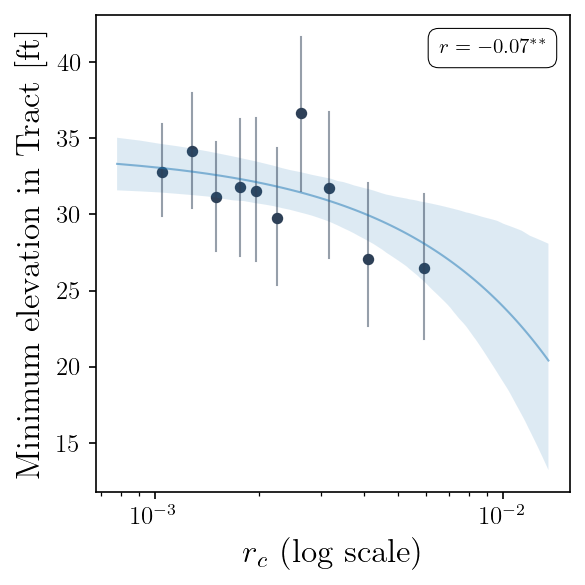

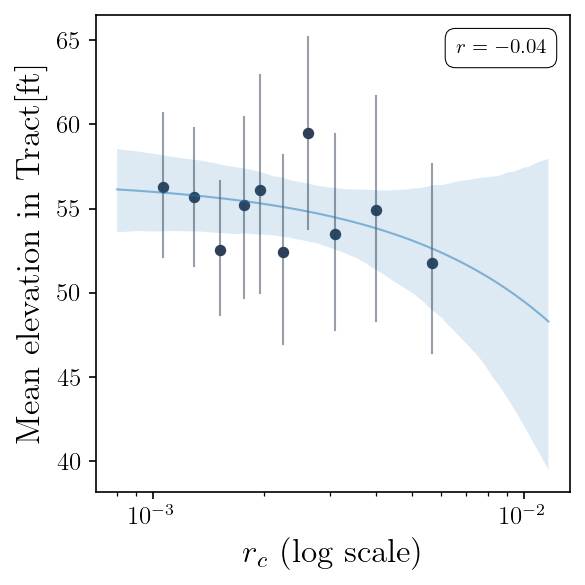

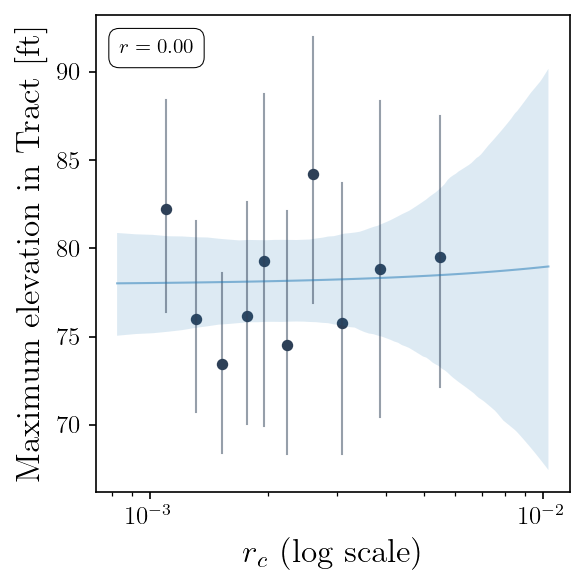

In [6]:
for cov in COVARIATES:
    plt.figure(figsize=(4, 4), dpi=150)
    
    # Get regression parameters for this covariate
    params = regression_params.get(cov, {'logistic': False, 'fit_reg': True})

    # trim analysis_df p_y to 0.01 and 0.99 quantiles to avoid outliers
    analysis_df = analysis_df[(analysis_df['p_y'] > analysis_df['p_y'].quantile(0.01)) & (analysis_df['p_y'] < analysis_df['p_y'].quantile(0.99))]
    # Get the actual range of x values
    x_min = analysis_df['p_y'].min()
    x_max = analysis_df['p_y'].max()
    
    ax = sns.regplot(
        data=analysis_df,
        x='p_y',
        y=cov,
        x_bins=10,
        logistic=params['logistic'],
        fit_reg=params['fit_reg'],
        scatter_kws={'alpha': 1, 'color': '#2E4057', 's': 20},
        truncate=True,  # This ensures the line stays within data bounds
        x_ci="ci",  # Keeps confidence intervals
    )
    
    # Additional constraint: manually remove any regression line segments outside data range
    if ax.lines:  # Check if there's a regression line
        line = ax.lines[0]
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        mask = (x_data >= x_min) & (x_data <= x_max)
        line.set_xdata(x_data[mask])
        line.set_ydata(y_data[mask])
    
    # Make the error bars thinner
    for line in ax.lines:
        line.set_linewidth(1)
        line.set_alpha(0.5)
    
    # Calculate Pearson correlation
    r, p = stats.pearsonr(analysis_df['p_y'], analysis_df[cov])
    
    # Add correlation text box
    if p < 0.001:
        text = f'$r = {r:.2f}^{{***}}$'
    elif p < 0.01:
        text = f'$r = {r:.2f}^{{**}}$'
    elif p < 0.05:
        text = f'$r = {r:.2f}^{{*}}$'
    else:
        text = f'$r = {r:.2f}$'
    
    # Position based on correlation sign
    x_pos = 0.05 if r > 0 else 0.95
    plt.text(x_pos, 0.95, text, 
             transform=ax.transAxes, 
             bbox=dict(facecolor='white', 
                      edgecolor='black',
                      alpha=1.0,
                      pad=3,
                      linewidth=0.5,
                      boxstyle='round,pad=0.5'),
             verticalalignment='top',
             horizontalalignment='left' if r > 0 else 'right')
    
    plt.xscale('log')
    plt.xlabel('$r_c$ (log scale)', fontsize=16)
    plt.ylabel(row_mapping[cov], fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{c.PAPER_PATH}/figures/external_covariates_corrs_{cov}.png', dpi=150, bbox_inches='tight', pad_inches=0.025)
    plt.show()